# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 09/14/2021

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
!pip uninstall statsmodels
!pip install statsmodels
!pip install geopandas
import geopandas as gpd #to work with spatial data
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels import tsa
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.distributions import empirical_distribution
import seaborn as sns
import scipy
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

Found existing installation: statsmodels 0.10.2
Uninstalling statsmodels-0.10.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.10.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 9.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 40.1 MB/s 
     |████████████████████████████████| 15.4 MB 68 kB/s 
     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [ ]:
#Import data files
#Can comment after first run 

# div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
# full_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63_WRA_all.csv', parse_dates=['DataDate'], index_col=['DataDate'])
# print(div_wd63.dtypes)
# print(full_wd63.dtypes)

In [ ]:
## RENAME THE COLUMNS TO MATCH OLD TIMESERIES DESCRIPTIONS
## Can comment out after first run

# full_wd63 = full_wd63.rename(columns={'SiteID':'HydrologyID', 'FullName':'DiversionName',
#                                       'Description':'DiversionTypeDescription', 'DataDate':'DiversionDate'})

# ## replace SURPRISE VALLEY/MICRON with surprise_vy_micron to export CSV

# full_wd63['DiversionName'] = full_wd63['DiversionName'].replace(to_replace='SURPRISE VALLEY/MICRON',
#                                                                 value='SURPRISE_VALLEY_MICRON')

In [ ]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

# div_name = np.unique(full_wd63['DiversionName']) #get unique identifier for each div point
# print(div_name)

# for n in div_name:
#   canal = full_wd63[full_wd63['DiversionName']== n] #creates a dataframe for each canal name
#   canal = canal.sort_index() #sorts data by date
#   file_name = 'datasets/diversion_timeseries/fulltime_individual_canals/'+ str(n) +'.csv' #creates a file path
#   canal.to_csv(file_name) #exports csv to directory

In [4]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###

all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/fulltime_individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DataDate'], index_col=['DataDate'])
  all_files.append(df) #appends dataframes to one file list

In [ ]:
#Plot the data to see the timescale

###----------------------------------###
### CREATES ONE FIGURE FOR ALL PLOTS ###
###----------------------------------###

len(all_files)
i,j = 0,0
plot_row = 4 #number of plots per row in figure
figure, ax = plt.subplots(33, plot_row, figsize=(30,150)) #create the figure
file_len = np.array(np.arange(0,len(all_files),1)) #total count of files

for f in file_len: #run a for loop to add all plots to figure
  canal_data = all_files[f] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'], 'o')
  ax[i][j].set_ylabel('Discharge (cfs)')
  ax[i][j].set_xlabel('Time')
  ax[i][j].title.set_text(canal_data['DiversionName'].iloc[0])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

###---------------------------------------------###
### CREATES INDIVIDUAL PLOTS FOR EACH DIVERSION ###
###---------------------------------------------###

for f in file_len:
  canal_data = all_files[f]
  fig = plt.figure(figsize= (9,7))
  ax = fig.add_subplot(1,1,1)
  ax.plot(canal_data.index, canal_data['CFS'], 'o')
  ax.set_ylabel('Discharge (cfs)')
  ax.set_xlabel('Time')
  ax.title.set_text(canal_data['DiversionName'].iloc[0])
  file_path = ('datasets/diversion_timeseries/individualplots/'+ canal_data['DiversionName'].iloc[0] +'.png')
  plt.savefig(file_path) #exports the file 


In [80]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Select only the diversions known to serve irrigation districts
#  Will remove reservoir, natural flow, and return flow data

diversion_list = [] #create a list to store the diversion data frame in

for i in range(len(all_files)):
  sel_data = all_files[i]
  data_type = sel_data['DiversionTypeDescription'][1]
  if data_type == ('Diversion' or 'Non-consumptive' or 'Combined Use'):
    diversion_list.append(sel_data)
  else:
    None

## Select diversions with data from 1987-2021 for study
## All else is discarded

fullextent_list = []

for i in range(len(diversion_list)):
  sel_data = diversion_list[i]
  oldest_year = sel_data.index.year[0]
  if oldest_year <= 1987:
    fullextent_list.append(sel_data)
  else:
    None

## Crop each time series with full extent range to desired time series

croppped_data = []

for i in fullextent_list:
  sel_data = i
  if sel_data.index.year[-1]>=1987:
    crop = sel_data.truncate(before='1987-01-01')
    croppped_data.append(crop)
  else:
    None

## Find the names of all the canals in the dataframe list

names = []

for i in croppped_data:
  canal = i['DiversionName']
  names.append(canal[0])

## Fill in any missing winter values with 0 starting at 1987-01-01

dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canals = []

for i in range(len(croppped_data)):
  canal = croppped_data[i] #selects the specific diversion dataframe
  canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
  canal = canal.drop(labels=0, axis=1) #dropes the series column
  canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
  canal = canal.asfreq('d') #fill each daily value
  canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
  canal['DiversionName'] = canal['DiversionName'].fillna(names[i]) #fills Nan diversion name values
  canals.append(canal)


In [77]:
## IMPORT RESERVOIR FILL FILE TO NORMALIZE DIVERTED VOLUME TO AVAILABLE WATER ##
## -------------------------------------------------------------------------- ##
## Try two metrics: 
##       1) Max reservoir fill
##       2) Fill at the earliest start of the irrigation season
## -------------------------------------------------------------------------- ##

fill = pd.read_csv('datasets/diversion_timeseries/reservoir_fill.csv', parse_dates=['DateTime'], index_col=['DateTime'])

## Find the max fill every year

max_fill = []
years = np.array(np.arange(1987,2021,1)) #creates an array for the years

for i in range(len(years)):
  data = fill[fill.index.year == years[i]]
  max_fill.append([years[i], np.max(data['total_storage'])])

max_fill = pd.DataFrame(max_fill, columns = ['Year', 'MaxFill'])





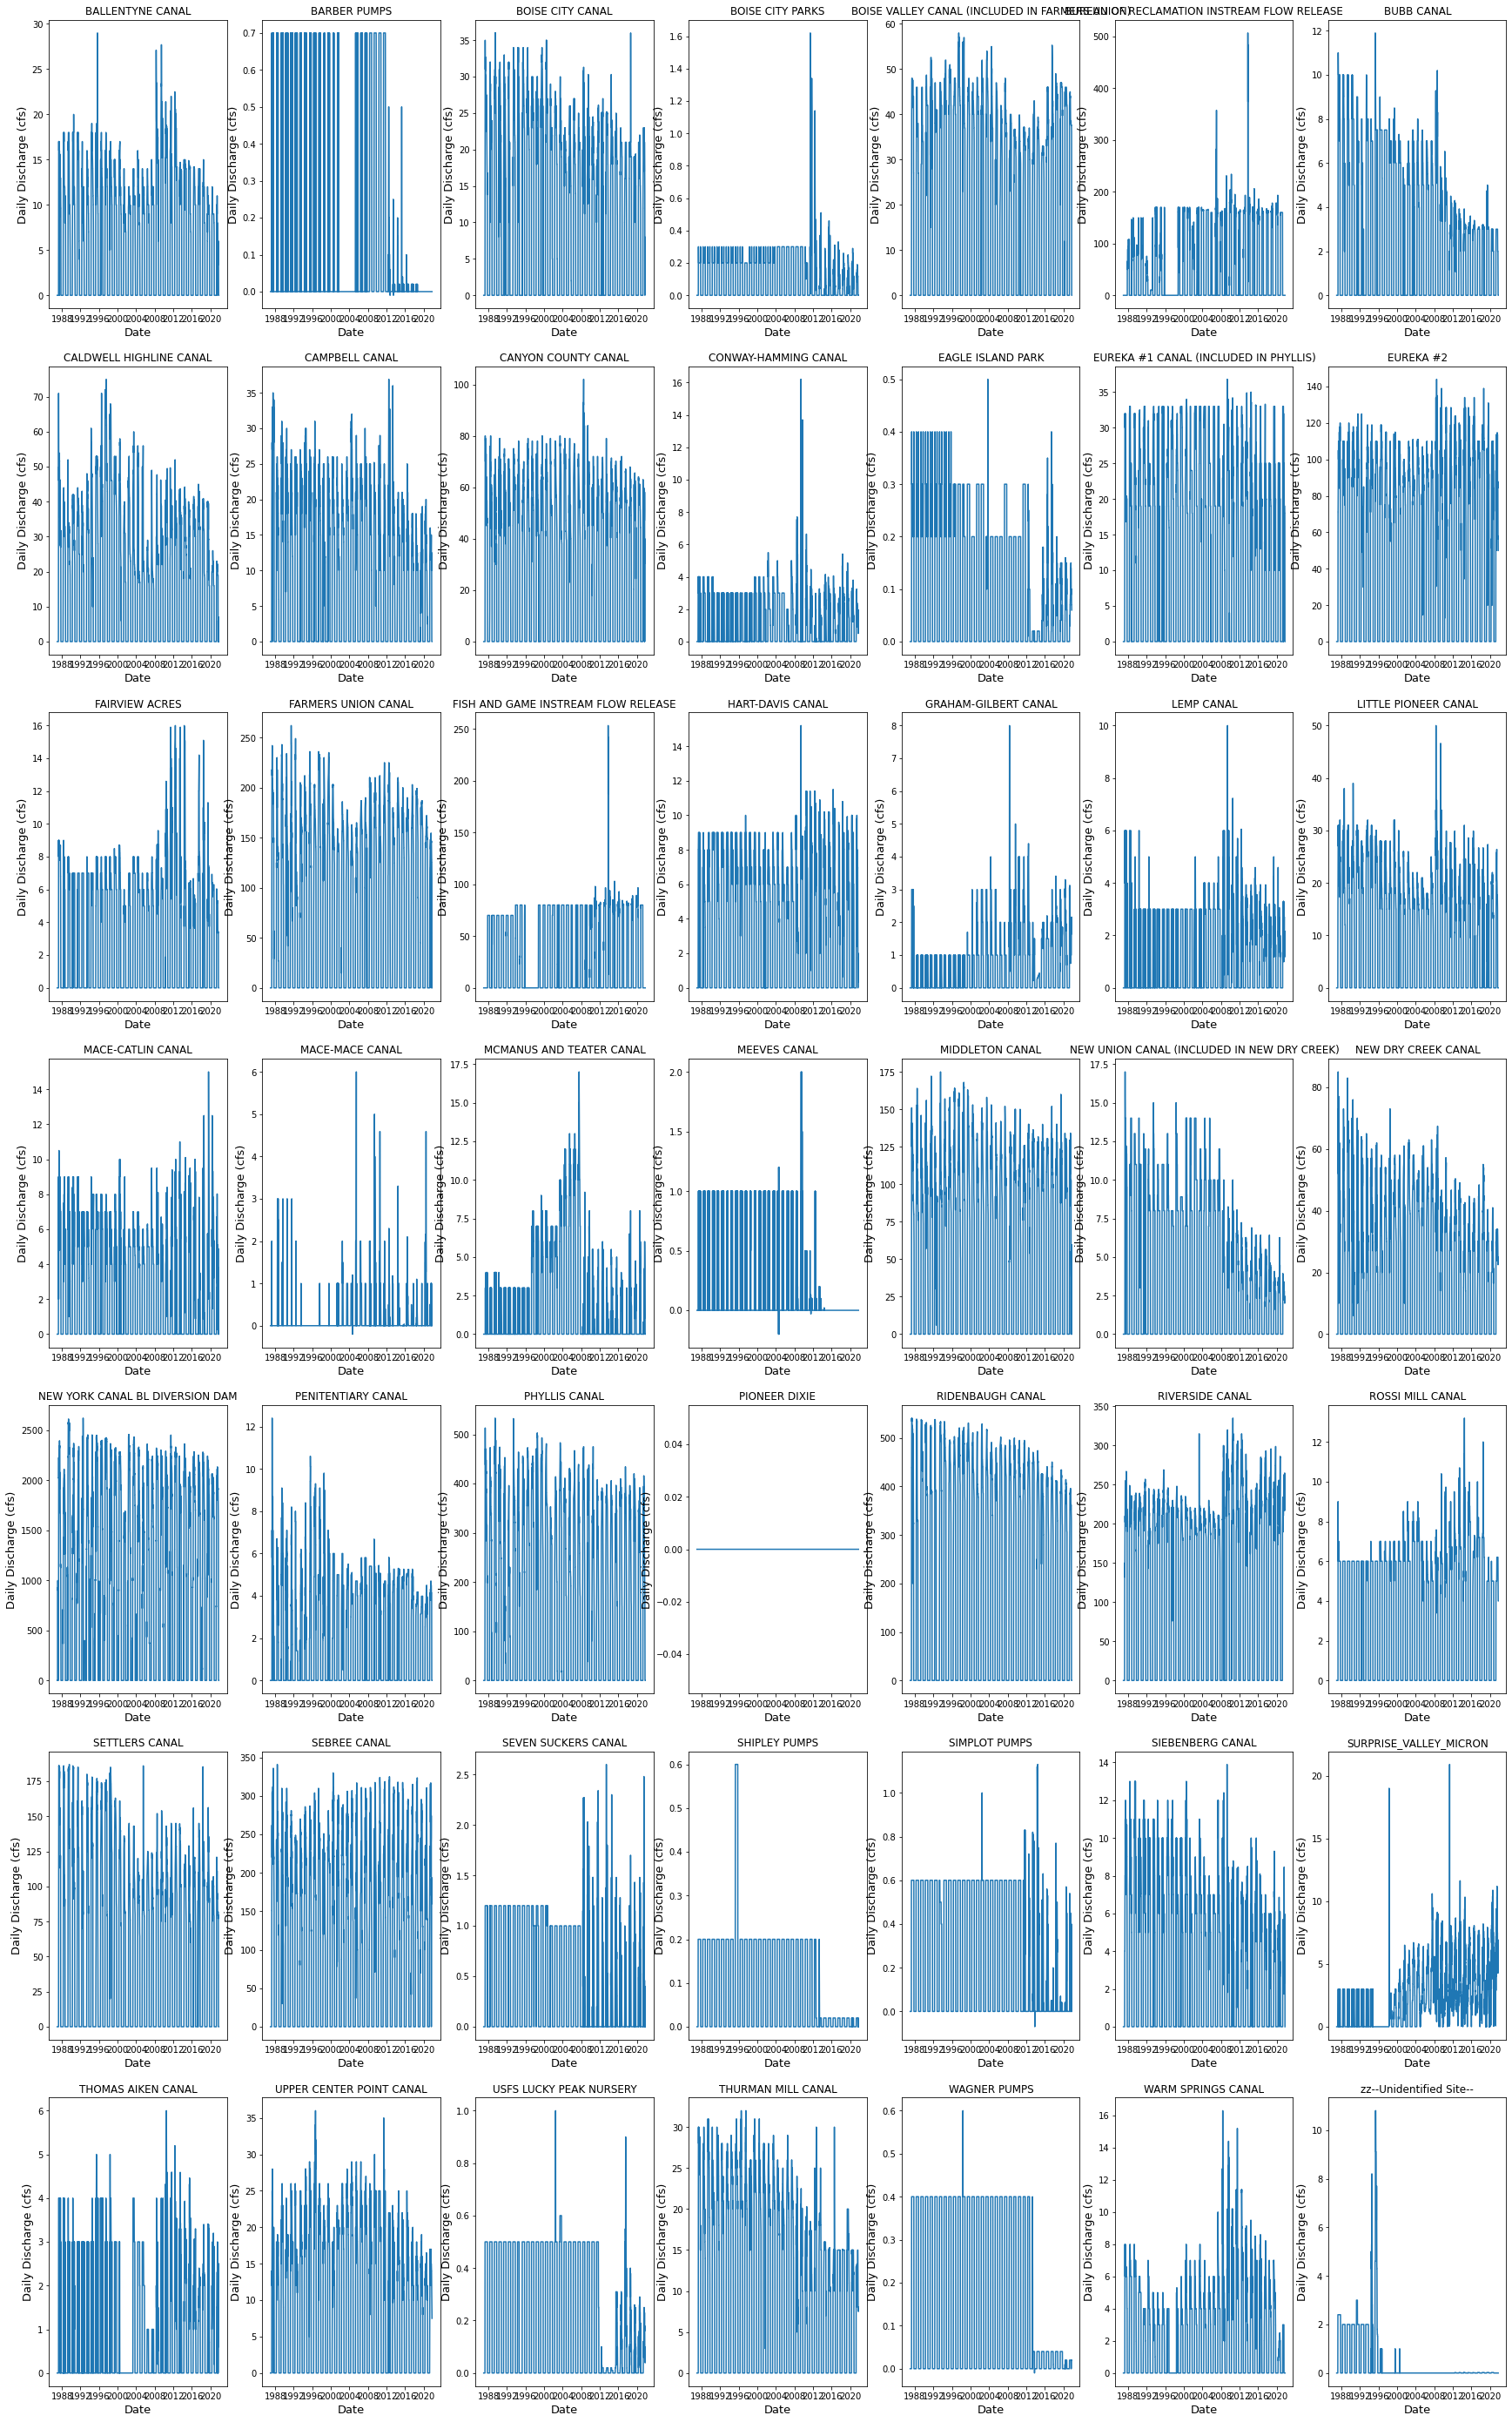

In [83]:
## PLOT THE RAW DATA TO VISUALLY ANALYZE TRENDS AND SEASONALITY

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(7, plot_row, figsize=(30,50)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = canals[n] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'])
  ax[i][j].set_ylabel('Daily Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Date', size=13)
  ax[i][j].title.set_text(names[n])
  # ax[i][j].set_xticks(years)
  # ax[i][j].set_xticklabels(years, rotation=45)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/rawdata.png')


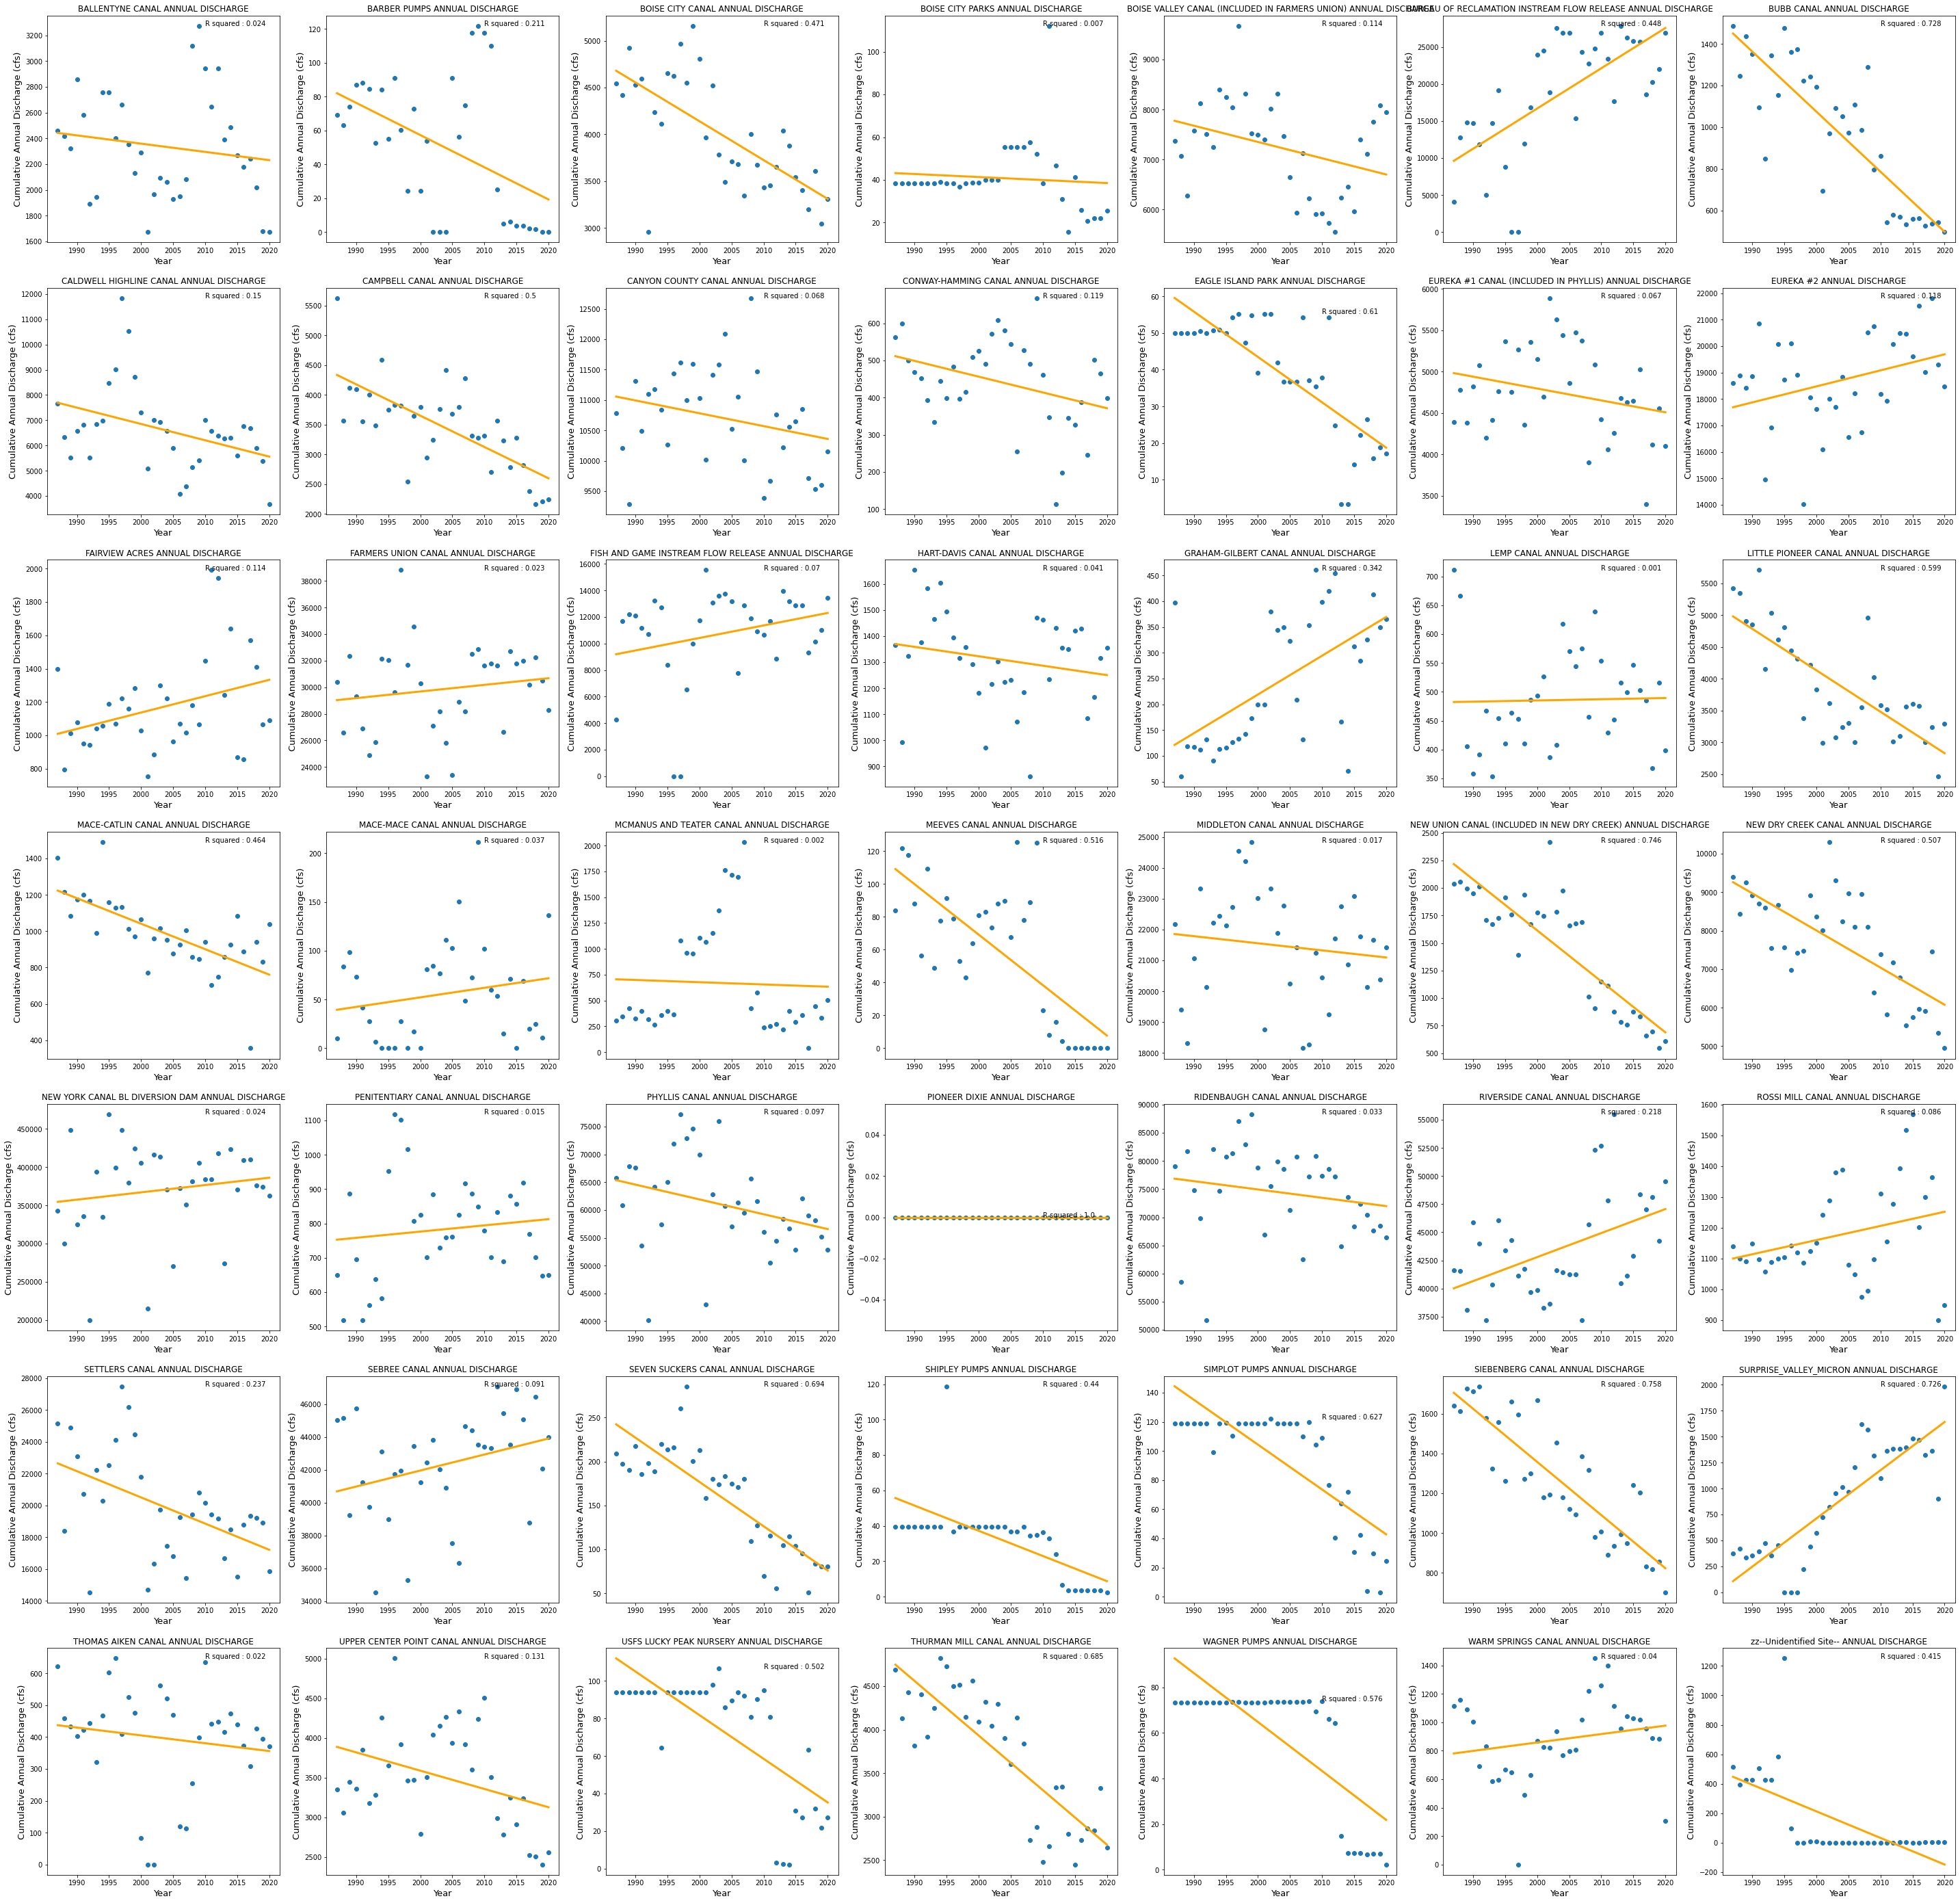

In [90]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

totals = np.empty((len(years), len(canals)))

for i in range(len(canals)):
  for y in range(len(years)):
    sub_canal = canals[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['CFS']) #sum the total discharge throughout the year
    #need to find a way to normalize the total for the year

## CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(totals[:,i], regression[:,i]) #compares correlation of model to true values


## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(7, plot_row, figsize=(50,50)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

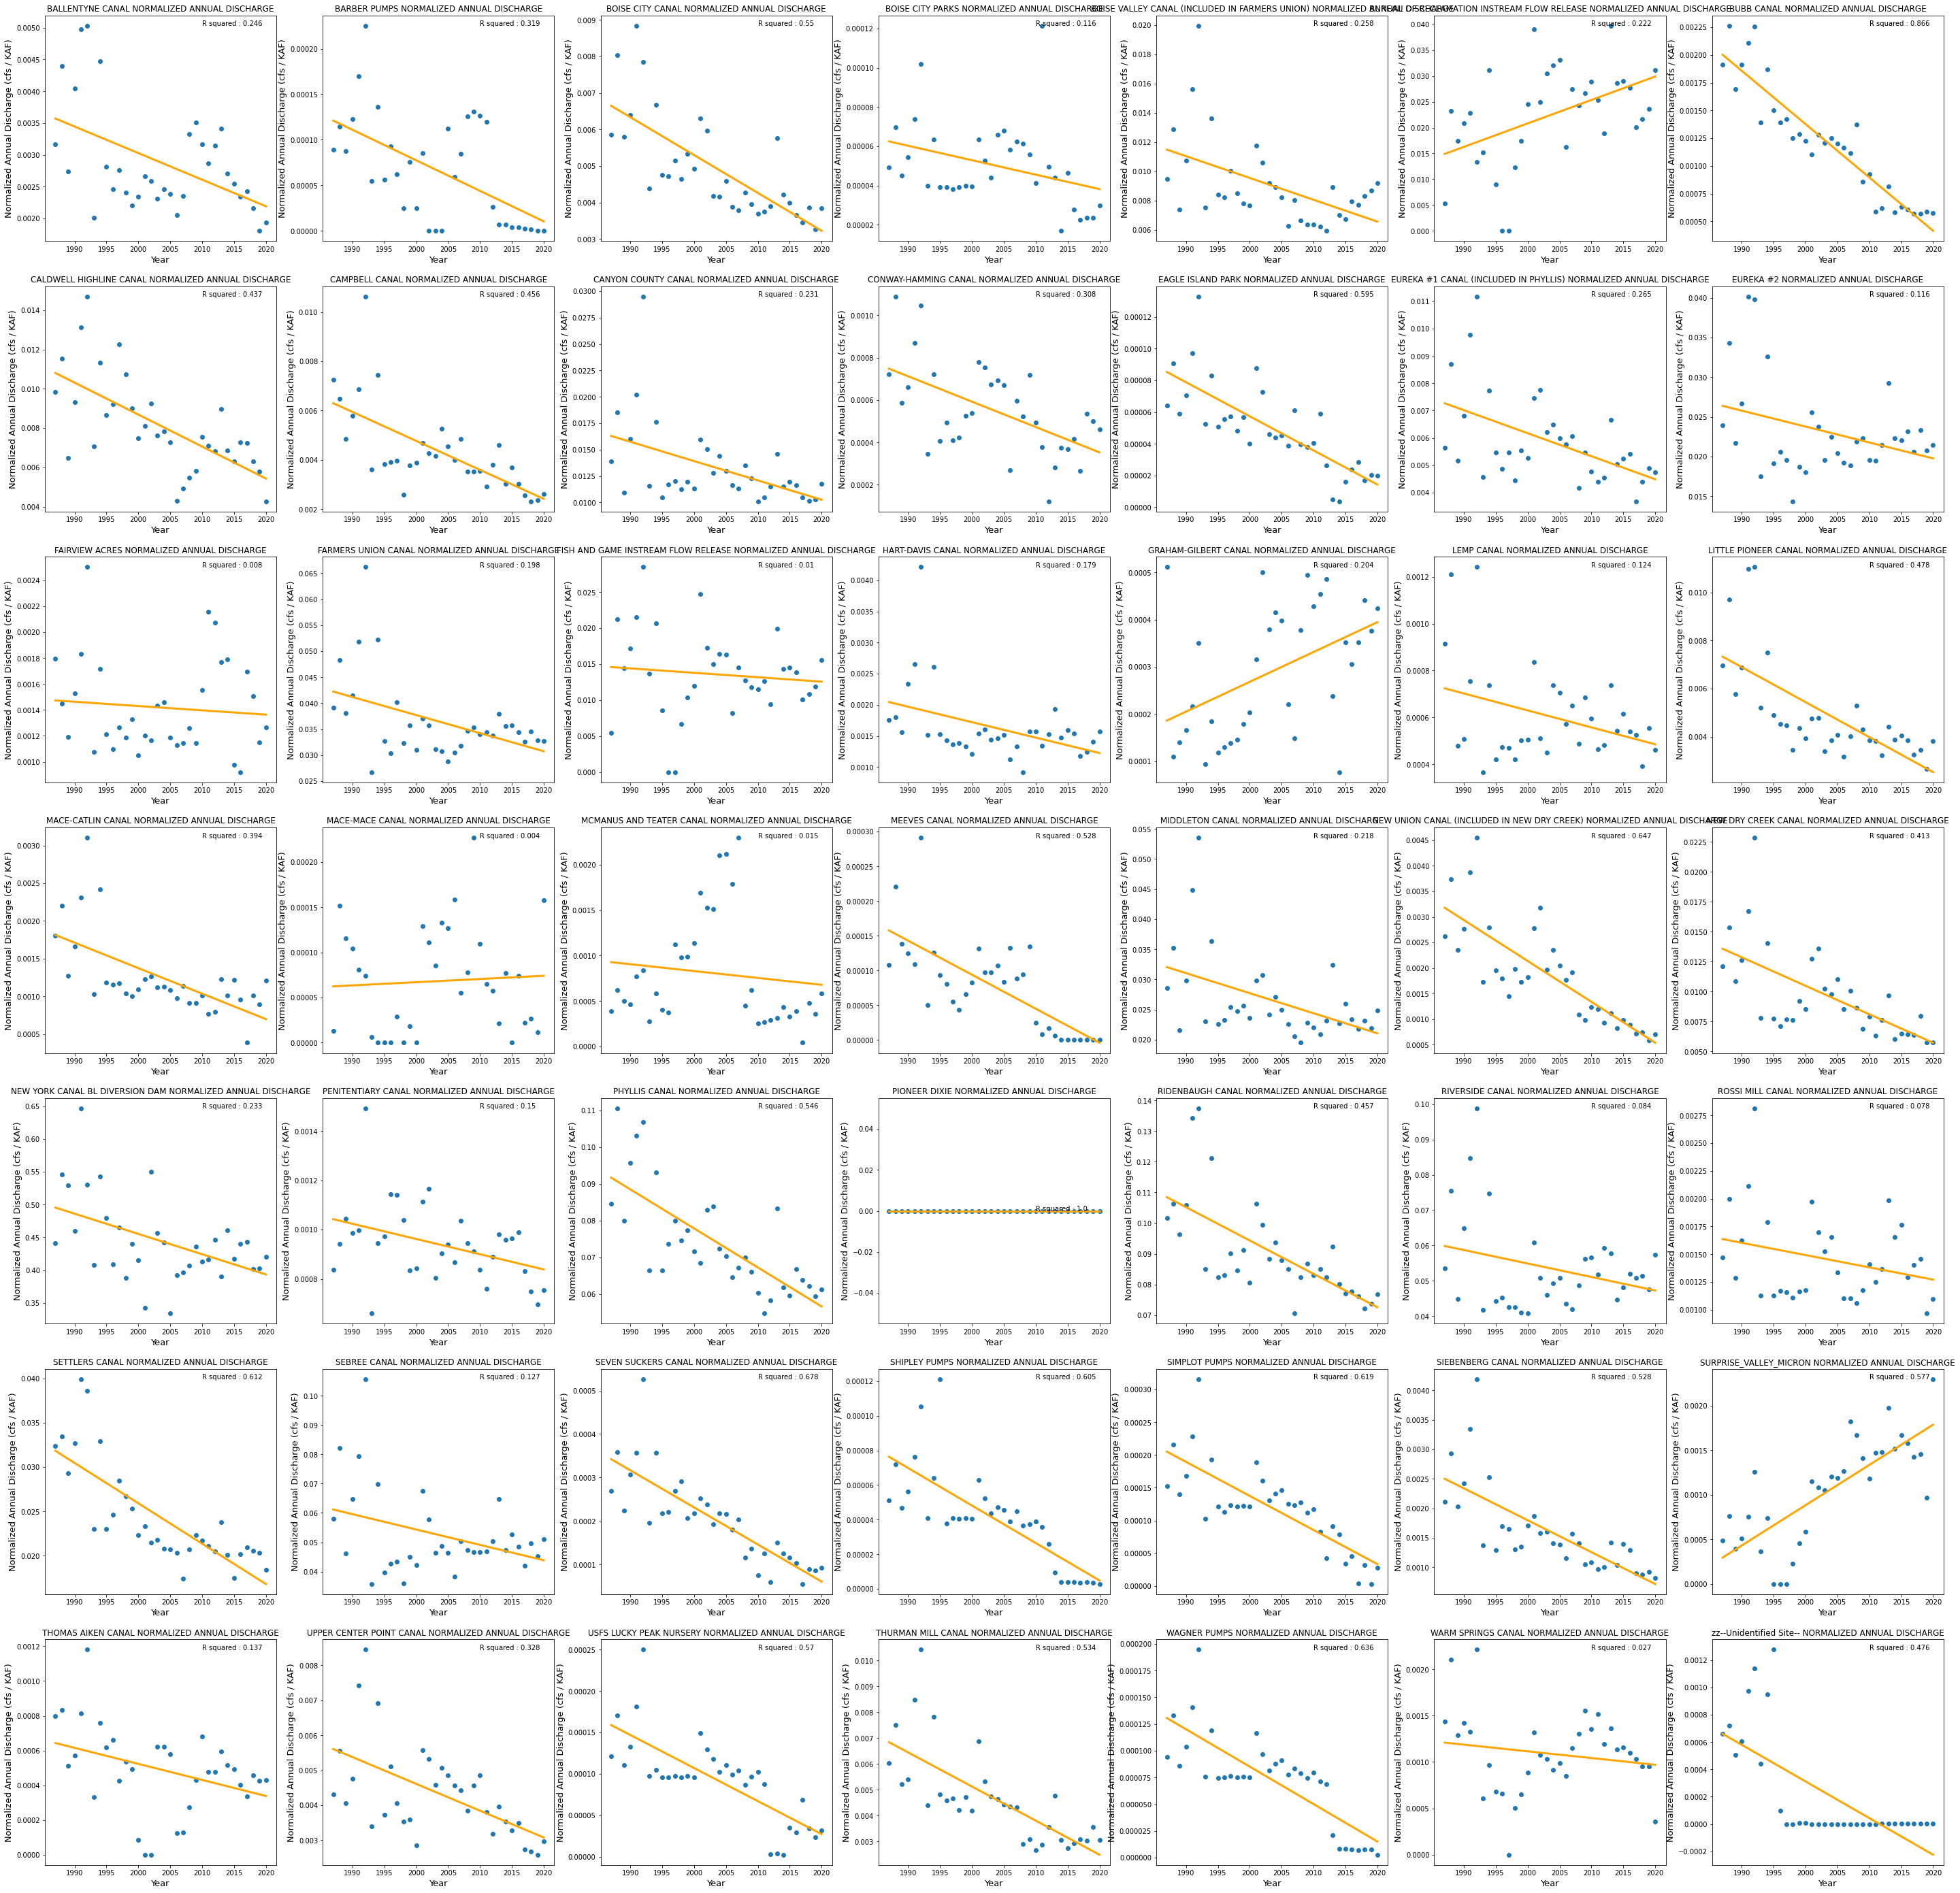

In [91]:
## Normalize total water diverted to the max fill available that year

norm_totals = np.empty((len(years), len(canals)))

for y in range(len(years)):
  for i in range(len(canals)):
    cum_discharge = totals[y][i]
    res_fill = max_fill['MaxFill'][max_fill['Year'] == years[y]]
    norm_totals[y][i] = cum_discharge/res_fill

# CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, norm_totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(norm_totals[:,i], regression[:,i]) #compares correlation of model to true values

## Plot the normalized discharges

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(7, plot_row, figsize=(50, 50)) #create the figure
for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = norm_totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Normalized Annual Discharge (cfs / KAF)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' NORMALIZED ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(norm_totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/norm_totals.png')


In [95]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(canals)):
  canal = canals[i]
  avg = np.mean(canal['CFS'][canal['CFS'] != 0])
  std_dev = np.std(canal['CFS'][canal['CFS'] != 0])
  avg_withzero = np.mean(canal['CFS'])
  std_withzero = np.std(canal['CFS'])
  coeff_var = std_dev/avg
  # coeff_var_withzero = std_withzero/avg_withzero
  maximum = np.max(canal['CFS'])
  minimum = np.min(canal['CFS'][canal['CFS'] != 0])
  stats.append([names[i], avg, std_dev, coeff_var, maximum, minimum, avg_withzero, std_withzero, coeff_var_withzero])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Mean', 'Standard_dev', 
                                            'Coefficient_Variation', 'Maximum', 'Minimum', 
                                            'Mean_ZeroValues', 'Standard_dev_ZeroValues',
                                            'Coefficient_ZeroValues'])


display(base_stats)
base_stats.to_csv('datasets/diversion_timeseries/figures/stats.csv')



DiversionName  ...  Coefficient_ZeroValues
0                                 BALLENTYNE CANAL  ...                1.072694
1                                     BARBER PUMPS  ...                1.072694
2                                 BOISE CITY CANAL  ...                1.072694
3                                 BOISE CITY PARKS  ...                1.072694
4   BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION)  ...                1.072694
5      BUREAU OF RECLAMATION INSTREAM FLOW RELEASE  ...                1.072694
6                                       BUBB CANAL  ...                1.072694
7                          CALDWELL HIGHLINE CANAL  ...                1.072694
8                                   CAMPBELL CANAL  ...                1.072694
9                              CANYON COUNTY CANAL  ...                1.072694
10                            CONWAY-HAMMING CANAL  ...                1.072694
11                               EAGLE ISLAND PARK  ...                1.072694
12           EUREKA #1 CANAL (INCLUDED IN PHYLLIS)  ...                1.072694
13                                       EUREKA #2  ...                1.072694
14                                  FAIRVIEW ACRES  ...                1.072694
15                             FARMERS UNION CANAL  ...                1.072694
16             FISH AND GAME INSTREAM FLOW RELEASE  ...                1.072694
17                                HART-DAVIS CANAL  ...                1.072694
18                            GRAHAM-GILBERT CANAL  ...                1.072694
19                                      LEMP CANAL  ...                1.072694
20                            LITTLE PIONEER CANAL  ...                1.072694
21                               MACE-CATLIN CANAL  ...                1.072694
22                                 MACE-MACE CANAL  ...                1.072694
23                        MCMANUS AND TEATER CANAL  ...                1.072694
24                                    MEEVES CANAL  ...                1.072694
25                                 MIDDLETON CANAL  ...                1.072694
26     NEW UNION CANAL (INCLUDED IN NEW DRY CREEK)  ...                1.072694
27                             NEW DRY CREEK CANAL  ...                1.072694
28                 NEW YORK CANAL BL DIVERSION DAM  ...                1.072694
29                              PENITENTIARY CANAL  ...                1.072694
30                                   PHYLLIS CANAL  ...                1.072694
31                                   PIONEER DIXIE  ...                1.072694
32                                RIDENBAUGH CANAL  ...                1.072694
33                                 RIVERSIDE CANAL  ...                1.072694
34                                ROSSI MILL CANAL  ...                1.072694
35                                  SETTLERS CANAL  ...                1.072694
36                                    SEBREE CANAL  ...                1.072694
37                             SEVEN SUCKERS CANAL  ...                1.072694
38                                   SHIPLEY PUMPS  ...                1.072694
39                                   SIMPLOT PUMPS  ...                1.072694
40                                SIEBENBERG CANAL  ...                1.072694
41                          SURPRISE_VALLEY_MICRON  ...                1.072694
42                              THOMAS AIKEN CANAL  ...                1.072694
43                        UPPER CENTER POINT CANAL  ...                1.072694
44                         USFS LUCKY PEAK NURSERY  ...                1.072694
45                              THURMAN MILL CANAL  ...                1.072694
46                                    WAGNER PUMPS  ...                1.072694
47                              WARM SPRINGS CANAL  ...                1.072694
48                         zz--Unidentified Site--  ...                1.072694

[49 rows x 9 columns]

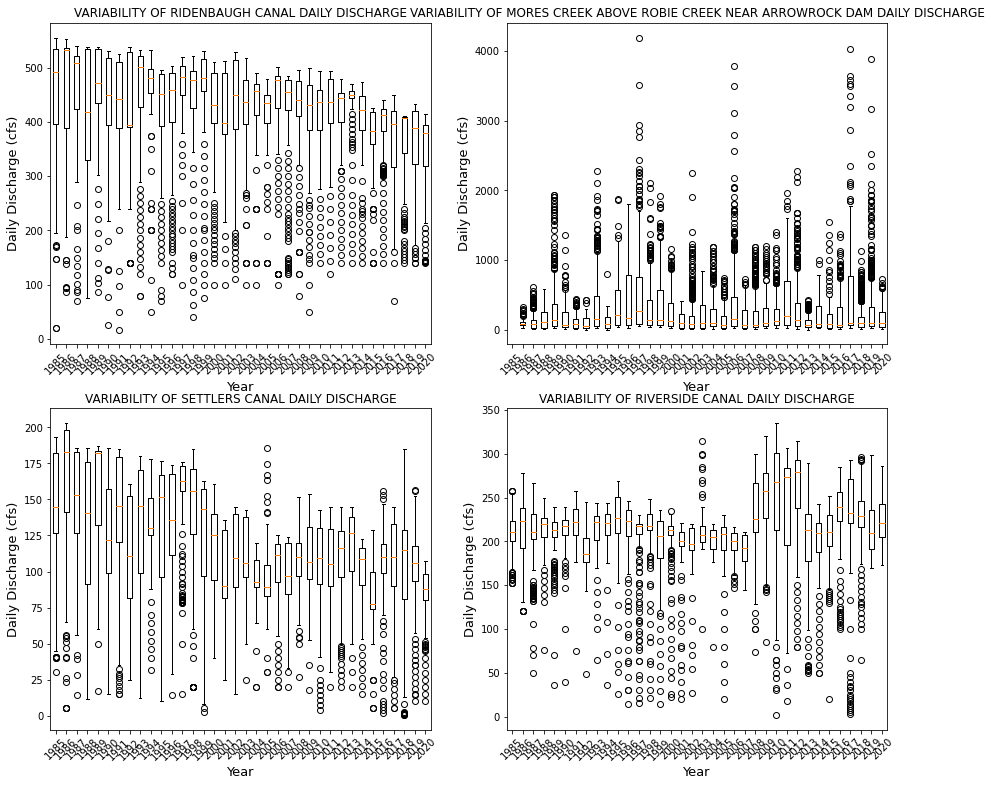

In [ ]:
## Create boxplot to show daily variability across the years

box_array = []

# Ridenbaugh canal
canal = canals[0]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array.append(cfs_year)

#Settlers Canal
box_array1 = []
canal = canals[1]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array1.append(cfs_year)

# Phyllis Canal
box_array2 = []
canal = canals[2]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array2.append(cfs_year)

# Riverside Canal 
box_array3 = []
canal = canals[3]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array3.append(cfs_year)

box_array_rid = np.array(box_array, dtype='object')
box_array_set = np.array(box_array1, dtype='object')
box_array_phyl = np.array(box_array2, dtype='object')
box_array_riv = np.array(box_array3, dtype='object')

fig, ax = plt.subplots(2, plot_row, figsize=(15,13))

ax[0][0].boxplot(box_array_rid)
ax[0][0].set_title('VARIABILITY OF '+ names[0]+' DAILY DISCHARGE')
ax[0][0].set_xlabel('Year', size=13)
ax[0][0].set_ylabel('Daily Discharge (cfs)', size=13)
ax[0][0].set_xticklabels(years, rotation=45)
ax[0][1].boxplot(box_array_set)
ax[0][1].set_title('VARIABILITY OF '+ names[1]+' DAILY DISCHARGE')
ax[0][1].set_xlabel('Year', size=13)
ax[0][1].set_ylabel('Daily Discharge (cfs)', size=13)
ax[0][1].set_xticklabels(years, rotation=45)
ax[1][0].boxplot(box_array_phyl)
ax[1][0].set_title('VARIABILITY OF '+ names[2]+' DAILY DISCHARGE')
ax[1][0].set_xlabel('Year', size=13)
ax[1][0].set_ylabel('Daily Discharge (cfs)', size=13)
ax[1][0].set_xticklabels(years, rotation=45)
ax[1][1].boxplot(box_array_riv)
ax[1][1].set_title('VARIABILITY OF '+ names[3]+' DAILY DISCHARGE')
ax[1][1].set_xlabel('Year', size=13)
ax[1][1].set_ylabel('Daily Discharge (cfs)', size=13)
ax[1][1].set_xticklabels(years, rotation=45)



plt.savefig('datasets/diversion_timeseries/figures/boxplot_variable.png')


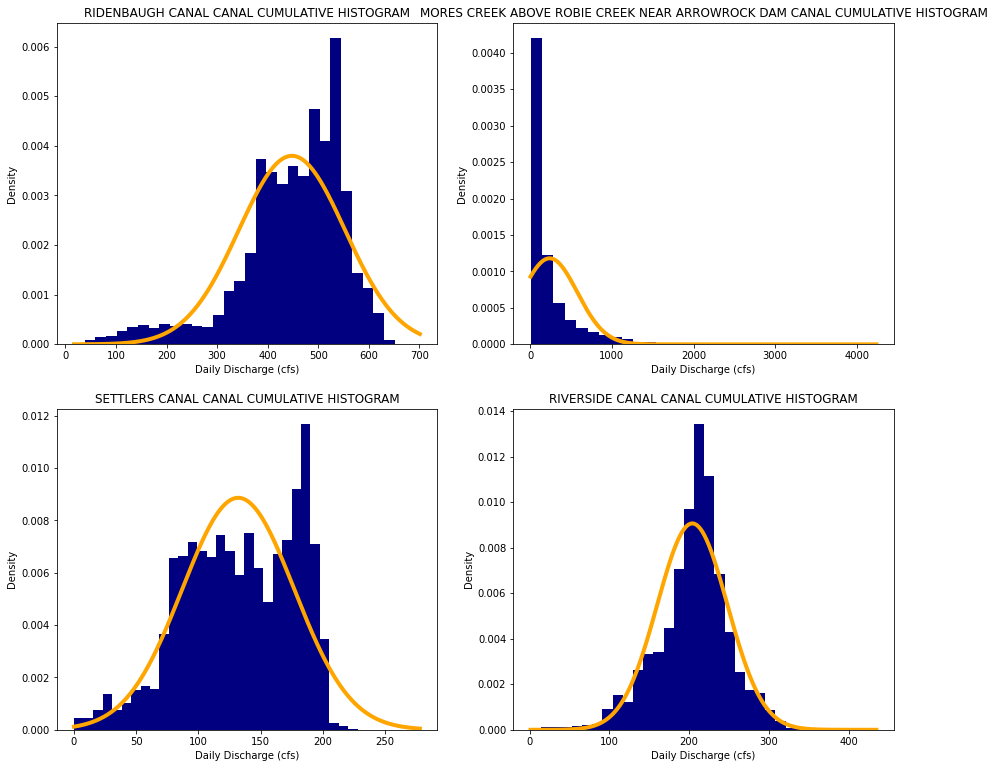

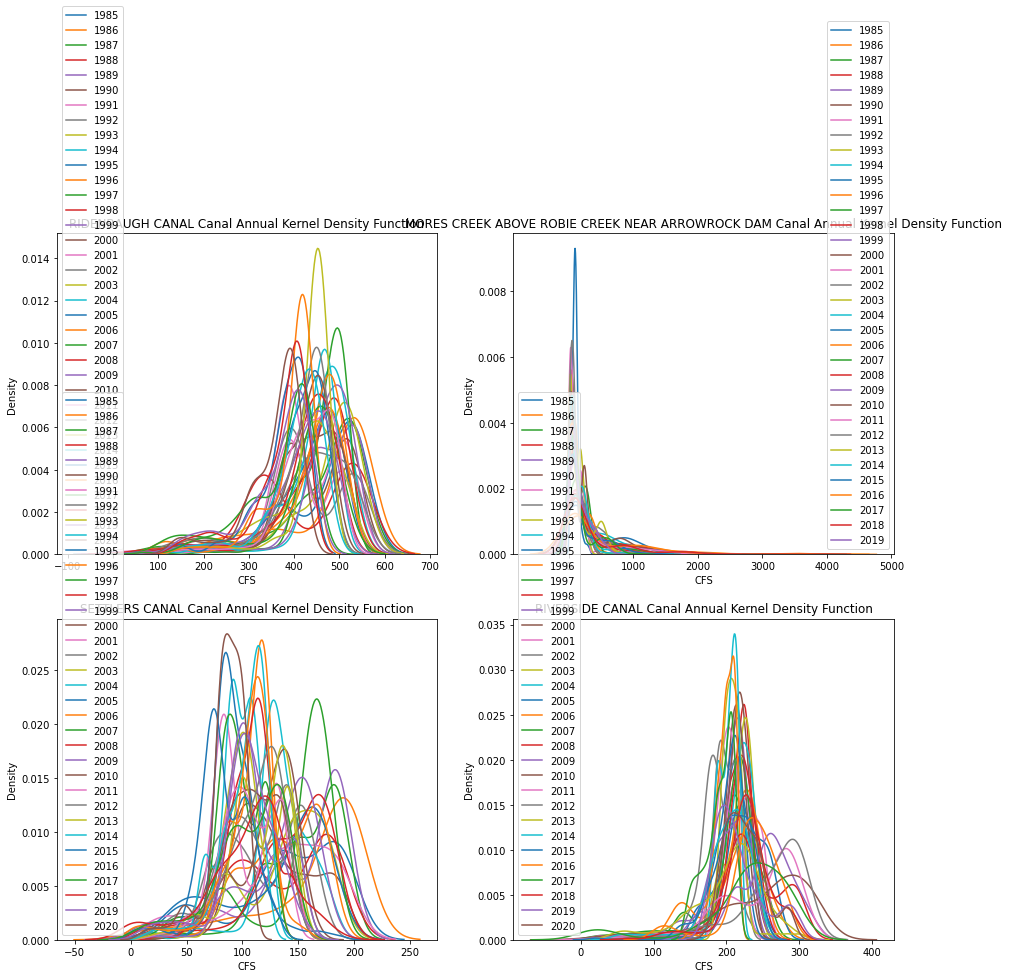

In [ ]:
## plot the KDE per year with the normal distribution over the top

#Define a normal PDF function
def mynormpdf(x, mean, std): 
  A = 1/(std*np.sqrt(2*np.pi))
  B = (x-mean)**2
  C = 2*std**2
  f = A*np.exp(-B/C)
  return f #returns the probability density for x, the mean of x, and the std dev of x 

## Plot the total histrogram of discharge with a normal pdf overlay 

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15, 13)) #create the figure

for n in range(len(canals)):
  max_canal, min_canal = [int(base_stats['Maximum'][base_stats['DiversionName'] == names[n]]), 
                          int(base_stats['Minimum'][base_stats['DiversionName'] == names[n]])]
  # Create a linespace of the max and min diversion rate for each canal and set the normal distribution to that range
  x_vals = np.linspace(min_canal, max_canal+50, num = (max_canal+50-min_canal))
  # Creat the normal distribution using total mean and total std deviation
  normal_pdf = mynormpdf(x_vals, int(base_stats['Mean'][base_stats['DiversionName'] == names[n]]), 
                         int(base_stats['Standard_dev'][base_stats['DiversionName'] == names[n]]))
  canal = canals[n]
  ax[i][j].hist(canal['CFS'][canal['CFS'] != 0], bins=30, density=True, cumulative=False, color = 'navy')
  ax[i][j].plot(x_vals, normal_pdf, color = 'orange', linewidth = 4)
  ax[i][j].set_title(str(names[n])+' CANAL CUMULATIVE HISTOGRAM')
  ax[i][j].set_ylabel('Density')
  ax[i][j].set_xlabel('Daily Discharge (cfs)')
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

plt.savefig('datasets/diversion_timeseries/figures/histogram')
plt.show()

## Plot the yearly KDE with legend to select years that are similar and group them together

del ax

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, axis = plt.subplots(2, plot_row, figsize=(15, 13)) #create the figure

for n in range(len(canals)):
  axis[i][j].set_title(str(names[n])+' Canal Annual Kernel Density Function')
  for y in range(len(years)):
    canal = canals[n]
    canal = canal[canal.index.year == years[y]]
    sns.kdeplot(canal['CFS'][canal['CFS'] != 0], cumulative=False, ax=(axis[i][j]))
    axis[i][j].legend(years)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

plt.savefig('datasets/diversion_timeseries/figures/kde.png')
plt.show()


In [ ]:
## Calcualte the kernel density estimate for each year in a canal and compare between years using RMSE 

dx = 0.5 #step change
x = np.arange(0, 600, dx) #xrange to create kde over
h = 20 #window size
kdf = np.empty((len(canals), len(x), len(years)))

## Create the kde over x for each year of a canal

for i in range(len(canals)):
  for y in range(len(years)):
    canal = canals[i]
    canal_year = canal[canal.index.year == years[y]]
    nc, xbins, patches = plt.hist(canal_year['CFS'][canal_year['CFS'] != 0], 30)
    plt.close()
    for n in range(len(x)):
      x0 = x[n].copy()
      w = scipy.stats.norm.pdf(canal_year['CFS'][canal_year['CFS'] != 0], x0, h)
      kdf[i][n][y] = np.sum(w)
      kdf[i,:,y] = kdf[i, :, y]/(np.sum(kdf[i, :, y]*dx))

## Calculate the RMSE between each year within a canal

rmse = []

for i in range(len(canals)):
  pdfs = kdf[i,:,:]
  for y in range(len(years)):
    kdf_year = pdfs[:,y]
    for n in range(len(years)):
      compare = pdfs[:,n]
      rmse_samp = np.sqrt(np.mean((kdf_year-compare)**2))
      rmse.append([names[i], years[y], years[n], rmse_samp])

rmse = pd.DataFrame(rmse, columns=['Name', 'YearSelect', 'YearCompare', 'RMSE'])

##Want to get rid of duplicate years (like getting rid of half of a correlation matrix)

new_rmse = []

for i in range(len(canals)):
  rid = rmse[rmse['Name'] == names[i]]
  # Desired data frame
  new_data = pd.DataFrame()
  # Concat numbers and corresponding letters
  new_data['concat'] = rid[['YearSelect','YearCompare']].apply(lambda r: sorted(r), axis=1)
  rid['combos'] = new_data['concat']
  rid['combostring'] = [','.join(map(str, l)) for l in rid['combos']]
  rid = rid.drop_duplicates(subset='combostring', keep='first', inplace=False)
  del rid['combos']
  del rid['combostring']
  new_rmse.append(rid)

rid = new_rmse[0]
settler = new_rmse[1]
phyllis = new_rmse[2]
riverside = new_rmse[3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
## FIND THE CENTER OF MASS OF THE IRRIGATION SEASON ##

centroid = np.empty((len(years), len(canals)))
centroid_day = []

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    centroid[i][n] = round(np.sum(year.index.dayofyear*year['CFS'])/np.sum(year['CFS']))
    centroid_day.append(centroid[i][n])

## Find the volume at the centroid

centroid_vol = np.empty((len(years), len(canals)))
centroid_volume = []

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    centroid_day = centroid[i][n]
    centroid_vals = year[year.index.dayofyear<=centroid_day]
    centroid_vol[i][n] = sum(centroid_vals['CFS'])
    centroid_volume.append(sum(centroid_vals['CFS']))

## Check to see if there is a trend in the data through time

regression = np.empty((len(years), len(canals)))
r_squared = np.empty(len(canals))

for i in range(len(canals)):
  model = np.polyfit(years, centroid[:,i], deg=1)
  regression [:,i] = np.polyval(model, years)
  r_squared[i] = metrics.r2_score(centroid[:,i], regression[:,i])

regression_vol = np.empty((len(years), len(canals)))
r_squared_vol = np.empty(len(canals))

for i in range(len(canals)):
  model = np.polyfit(years, centroid_vol[:,i], deg=1)
  regression_vol [:,i] = np.polyval(model, years)
  r_squared_vol[i] = metrics.r2_score(centroid_vol[:,i], regression_vol[:,i])

## PLOT THE DAY AT CENTER OF MASS FOR EACH CANAL ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15,13), sharex=True, sharey=True) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = centroid[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n])
  ax[i][j].set_ylabel('Day of Year', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' CENTER OF MASS')
  ax[i][j].tick_params('both')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  ax[i][j].text(2005, np.max(canal_data), s='R squared : ' + str(np.around(r_squared[n], 4)), size=12)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/centroid_time.png')

## PRESENT THE VOLUME AT THE DAY OF CENTER OF MASS FOR EACH CANAL AS A TIMESERIES ##

fig6 = plt.figure(figsize=(11,17))
ax = fig6.add_subplot(2,1,1)
plt.xticks(years, years, rotation= 45)
ax.plot(years, centroid_vol, 'o')
ax.plot(years, regression_vol, color = 'black')
ax.set_ylabel('Cumulative Volume at Center of Mass', size=13)
ax.set_xlabel('Year', size=14)
leg = []
for i in range(len(names)):
  leg.append(names[i] + ' (' + str(np.around(r_squared_vol[i], 3)) + ')')
ax.legend(leg)
plt.savefig('datasets/diversion_timeseries/figures/centroid_vol.png')
plt.show()

# Boxplot comparing center of mass 

fig = plt.figure(figsize= (7,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot(centroid)
ax.set_xticklabels(names)
ax.set_xlabel('Canal Name', size=13)
ax.set_ylabel('Center of Mass Day of Year', size=13)
ax.set_title('Day of Center of Mass Across Diversions', size=14)
plt.savefig('datasets/diversion_timeseries/figures/box_centroid.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


ValueError: ignored

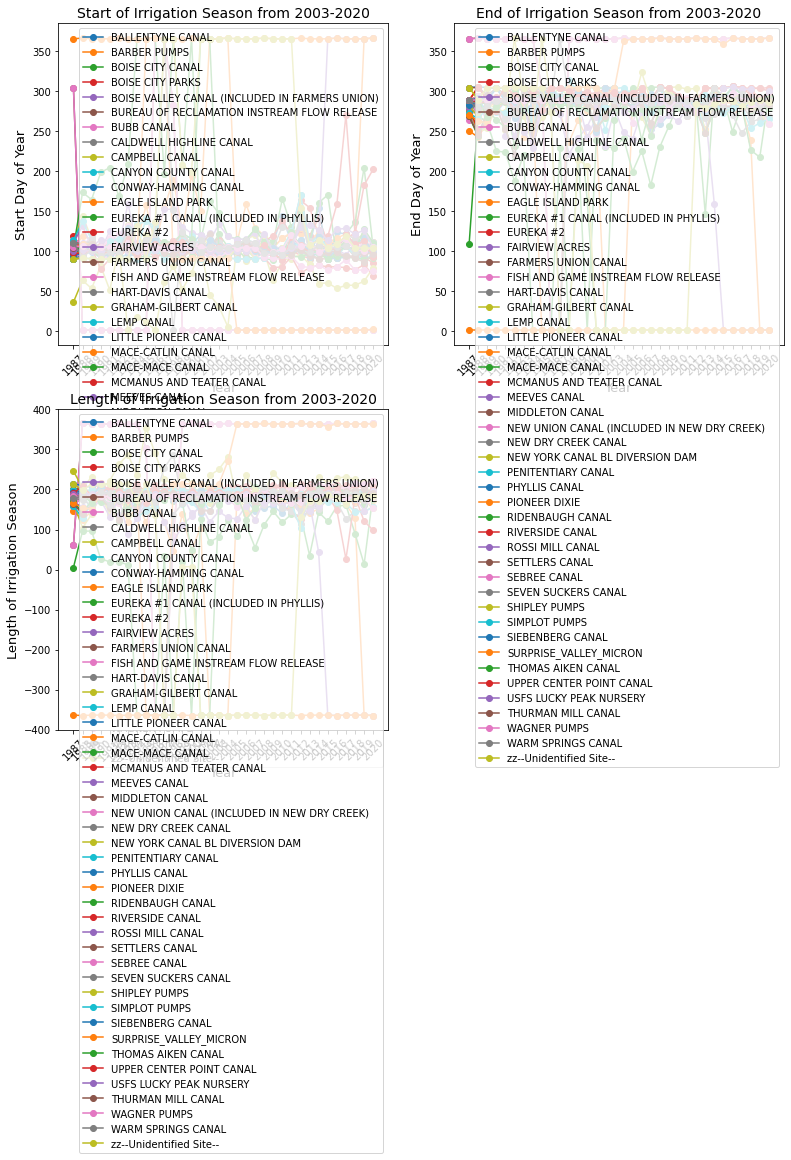

In [97]:
## PLOT LENGTH OF IRRIGATION SEASON ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

length = []

for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(canals)):
  for y in range(len(years)):
    canal_data = canals[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
    min_Ix = min_Ix[0]
    min_Ix = min_Ix[-1]
    start_date = canal_by_year.index[min_Ix]
    start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
    max_Ix= max_Ix[0]
    max_Ix = max_Ix[0]
    end_date = canal_by_year.index[max_Ix]
    end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    irrig_season_range = end_dayofyear-start_dayofyear
    length.append([canal_name, start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])

season_df = pd.DataFrame(length, columns = ['DiversionName', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range'])
season_df.to_csv('datasets/diversion_timeseries/figures/timing.csv')


## Visualize the start day, end day, and length of irrigation season ##

fig = plt.figure(figsize = (13,13))
ax = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)

for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax.plot(years, canal['StartDayofYear'], 'o-')
  ax.legend(names)
  ax.set_ylabel('Start Day of Year', size=13)
  ax.set_xlabel('Year', size=13)
  ax.set_xticks(years)
  ax.set_xticklabels(years, rotation=45)
  ax.set_title('Start of Irrigation Season from 2003-2020', size=14)
for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax1.plot(years, canal['EndDayofYear'], 'o-')
  ax1.legend(names)
  ax1.set_ylabel('End Day of Year', size=13)
  ax1.set_xlabel('Year', size=13)
  ax1.set_xticks(years)
  ax1.set_xticklabels(years, rotation=45)
  ax1.set_title('End of Irrigation Season from 2003-2020', size=14)
for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax2.plot(years, canal['Range'], 'o-')
  ax2.legend(names)
  ax2.set_ylabel('Length of Irrigation Season', size=13)
  ax2.set_xlabel('Year', size=13)
  ax2.set_xticks(years)
  ax2.set_xticklabels(years, rotation=45)
  ax2.set_title('Length of Irrigation Season from 2003-2020', size=14)

plt.savefig('datasets/diversion_timeseries/figures/timing_stats.png')
plt.show()


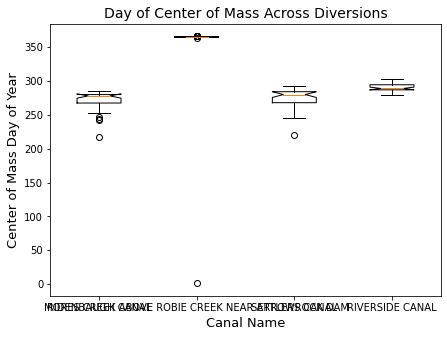

In [ ]:
fig = plt.figure(figsize= (7,5))
ax = fig.add_subplot(1,1,1)
rid_len = season_df['EndDayofYear'][season_df['DiversionName']==names[0]]
set_len = season_df['EndDayofYear'][season_df['DiversionName']==names[1]]
phyl_len = season_df['EndDayofYear'][season_df['DiversionName']==names[2]]
riv_len = season_df['EndDayofYear'][season_df['DiversionName']==names[3]]
lens = [rid_len, set_len, phyl_len, riv_len]
ax.boxplot(lens, notch=True)
ax.set_xticklabels(names)
ax.set_xlabel('Canal Name', size=13)
ax.set_ylabel('Center of Mass Day of Year', size=13)
ax.set_title('Day of Center of Mass Across Diversions', size=14)
plt.savefig('datasets/diversion_timeseries/figures/box_centroid.png')
plt.show()

In [ ]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(canals)):
  canal_timing = season_df[season_df['DiversionName'] == names[i]]
  avg_start = np.mean(canal_timing['StartDayofYear'])
  std_start = np.std(canal_timing['StartDayofYear'])
  avg_end = np.mean(canal_timing['EndDayofYear'])
  std_end = np.std(canal_timing['EndDayofYear'])
  avg_length = np.mean(canal_timing['Range'])
  std_length = np.std(canal_timing['Range'])
  avg_centroid = np.mean(centroid[:,i])
  std_centroid = np.std(centroid[:,i])
  avg_centroidvol = np.mean(centroid_vol[:,i])
  std_centroidvol = np.std(centroid_vol[:,i])
  time_stats.append([names[i], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length, avg_centroid, std_centroid, avg_centroidvol,
                     std_centroidvol])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length','avg_centroid', 'std_centroid', 
                                                 'avg_centroidvol', 'std_centroidvol'])

time_stats.to_csv('datasets/diversion_timeseries/figures/time_stats.csv')
display(time_stats)

NameError: ignored

In [ ]:
## Test if time series is stationary ##

## Augmented Dickey Fuller Test tests for stationarity
## Null hypothesis: time series is NOT stationary

# fuller = []

# for i in range(len(canals)):
#   canal = canals[i]
#   test = adfuller(canal['CFS'], autolag='AIC', regression='c') 
#   fuller.append([names[i], test[0], test[1], test[2]])

# stationary_test = pd.DataFrame(fuller, columns=['DiversionName', 'f-statistic', 'p-value', 'nlags'])
# stationary_test['DiversionName'] = names
# display(stationary_test)


## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
## Null hypothesis: time series IS stationary

# kpss_test = []

# for i in range(len(canals)):
#   canal_data = canals[i]
#   test = kpss(canal_data['CFS'], regression='c')
#   kpss_test.append([names[i], test[0], test[1], test[2]])

# kpss_results = pd.DataFrame(kpss_test, columns= ['DiversionName', 'TestStatistic', 'P-value', 'Lags'])
# display(kpss_results)

## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow

!pip install pymannkendall
import pymannkendall as mk

outs = []

for i in range(len(canals)):
  canal = canals[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  outs.append([names[i], trend, hyp, pval, slope])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
display(mannkend_out)




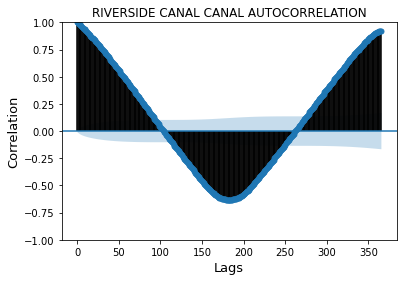

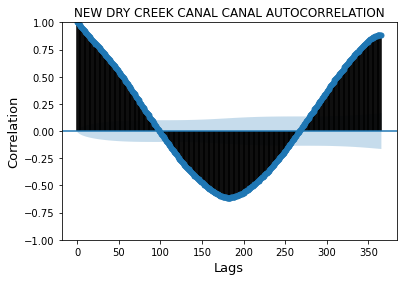

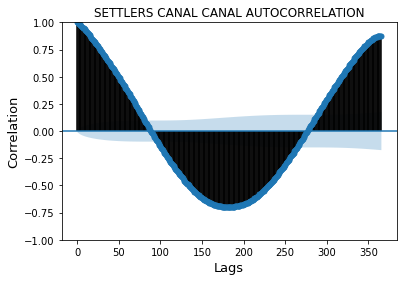

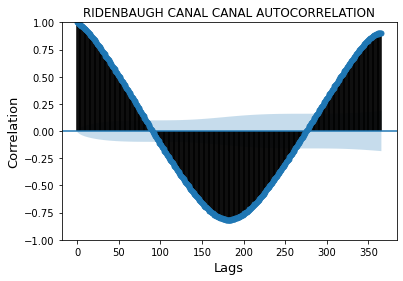

In [ ]:
## Look for autocorrelation in the seasonal component ##

#Run autocorrelation function

acf = []
for i in range(len(canals)):
  irrig = canals[i]
  acf.append(plot_acf(irrig['CFS'], title = irrig['DiversionName'][1]+' CANAL AUTOCORRELATION', lags=365))
  plt.ylabel('Correlation', size=13)
  plt.xlabel('Lags', size=13)
  plt.savefig('datasets/diversion_timeseries/figures/acf'+names[i]+'.png')



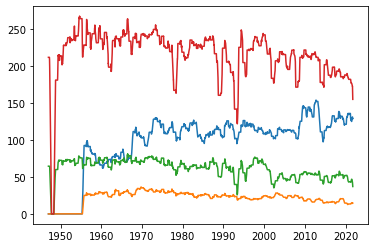

In [ ]:
## DETECT A TREND ##

sma = []

for i in range(len(canals)):
  canal = canals[i]
  sma.append((canal['CFS'].rolling(window=365).mean()))
  plt.plot(sma[i])



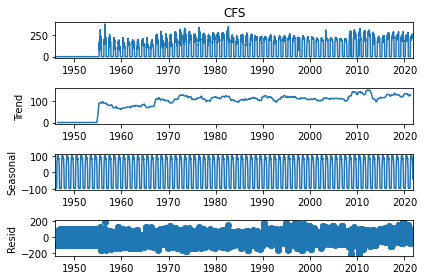

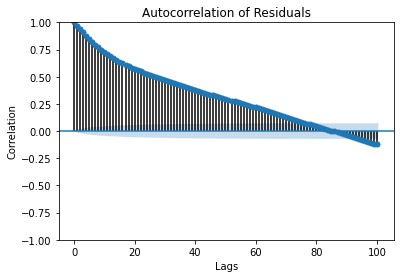

In [ ]:
## Seasonal decomposition of the data ##

rid = canals[0]
decomp = seasonal_decompose(rid['CFS'], model='additive', period=365)
decomp.plot()
plt.show()
resid = decomp.resid
nan_data = np.isnan(resid) #calls the nan values and creates a bool for nan vs number
not_nan_data = ~ nan_data #takes all the "True" values
data = resid[not_nan_data] #uses the location of the true values to create new array with no nan
plot_acf(data, title = 'Autocorrelation of Residuals', lags=100)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [ ]:
## AUTO ARIMA ## 

rid = canals[0]

rid_arima = auto_arima(rid['CFS'], start_p=1, start_q=1, max_p=3, max_q=12,
                       seasonal=True, d=0, seasonal_test='ocsb')

In [ ]:
rid_arima.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                27678
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -106728.787
Date:                Thu, 16 Dec 2021   AIC                         213469.573
Time:                        17:10:42   BIC                         213518.943
Sample:                             0   HQIC                        213485.475
                              - 27678                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0235      0.003      7.322      0.000       0.017       0.030
ar.L1          1.9874      0.003    763.856      0.000       1.982       1.993
ar.L2         -0.9877      0.003   -383.241      0.000      -0.993      -0.983
ma.L1         -0.9465      0.004   -219.821      0.000      -0.955      -0.938
ma.L2         -0.0397      0.003    -13.324      0.000      -0.046      -0.034
sigma2       131.0952      0.253    519.060      0.000     130.600     131.590
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):          30462484.73
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -1.76
Prob(H) (two-sided):                  0.00   Kurtosis:                       165.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""